# <center>Discretizing reading categories</center>

<center>last changed July 12, 2019</center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.porter import *

In [2]:
pd.read_csv(
    'MoreFiles/categories_edited.csv', 
    header=None
).to_csv(
    'MoreFiles/categories.csv', 
    sep='|', 
    index=False
)

In [3]:
f = [
    list(r[1]) 
    for r in pd.read_csv(
        'MoreFiles/categories.csv', 
        sep='|'
    ).iterrows()
]
f = [ln for ln in f if ln.count(np.nan) != len(ln)]

In [4]:
delimiter_idx = [
    tuple([idx, l[0]]) 
    for idx, l in enumerate(f) 
    if pd.isnull(l[1])
]

In [5]:
start = 0
grp_name_to_lns = {}
for n, tpl in enumerate(delimiter_idx[:-1]):
    grp_name = tpl[1]
    nxt = delimiter_idx[n+1][0]
    grp_name_to_lns[grp_name] = tuple([start, nxt])
    start = nxt
grp_name_to_lns[delimiter_idx[-1][1]] = tuple([start, len(f) - 1])

In [6]:
grp_name_to_subgrps_to_lns = {}
for grp_name, lns in grp_name_to_lns.items():
#     print('\n', grp_name)
    subgrp_name_to_notes = {}
    for x in f[lns[0] + 1:lns[1]]:
        subgrp_name = x[0]
        for note in x[1:]:
            if not pd.isnull(note):
                reg = note.strip().lower().replace(';', '')
                try:
                    subgrp_name_to_notes[subgrp_name].append(reg)
                except KeyError:
                    subgrp_name_to_notes[subgrp_name] = [reg]
    grp_name_to_subgrps_to_lns[grp_name] = subgrp_name_to_notes

In [7]:
obs_full = list(pd.read_csv(
    'DataFromFirstEmail/20190118_reading_specialists.csv'
).OBS)
obs_short = [
    [y.strip() for y in x.lower().replace('$obs:', '').strip().split(';')] 
    for x in obs_full
]
corpus = [
    x.replace('.', '').replace(',', '').replace('/', '').replace(
        'word by word',
        'word-by-word'
    )
    for y in obs_short 
    for x in y 
    if x
]

In [8]:
better_epr_iter = [
    tuple([grp_name, subgrp, ln.replace(
        'word by word',
        'word-by-word'
    )])
    for grp_name, subgrps_to_lns in grp_name_to_subgrps_to_lns.items()
    for subgrp, lns in subgrps_to_lns.items()
    for ln in lns
]

exact matches $\downarrow$

In [9]:
from collections import Counter

In [10]:
cntr = Counter()
matched = 0
for obs in corpus:
    for epr_cluster in better_epr_iter:
        if obs == epr_cluster[-1]:
            matched += 1
            cntr[epr_cluster[:-1]] += 1
            break
cntr_lst = sorted(
    [
        tuple(['-'.join(k), v]) 
        for k, v in dict(cntr).items()
    ], 
    key=lambda kv: -kv[1]
)
_c = list(zip(*cntr_lst))
k, v = _c[0], _c[1]

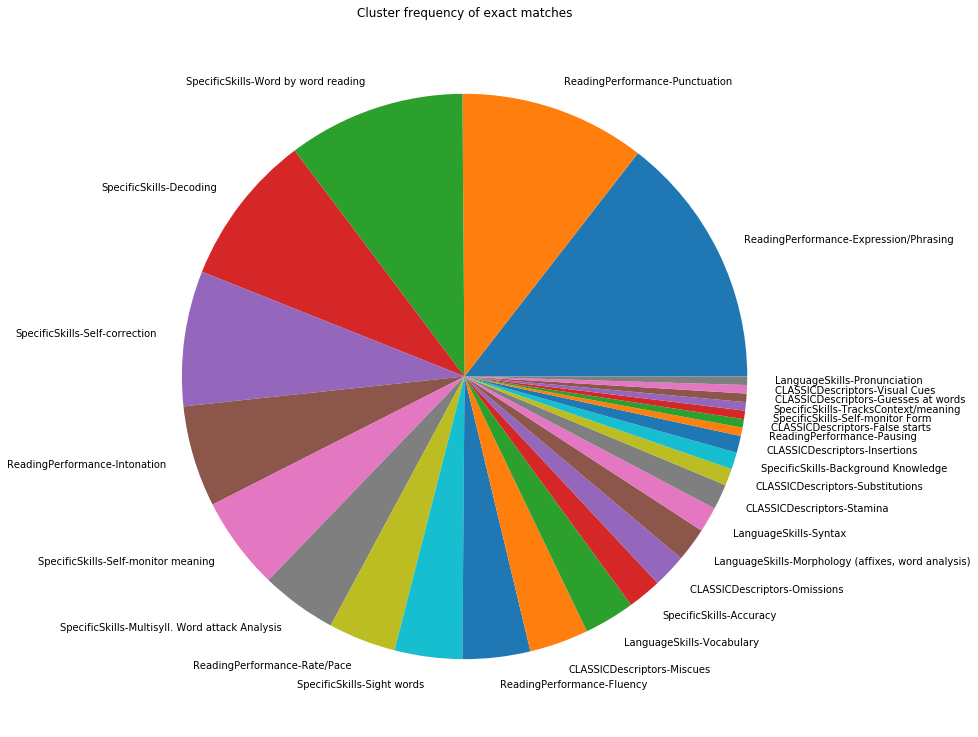

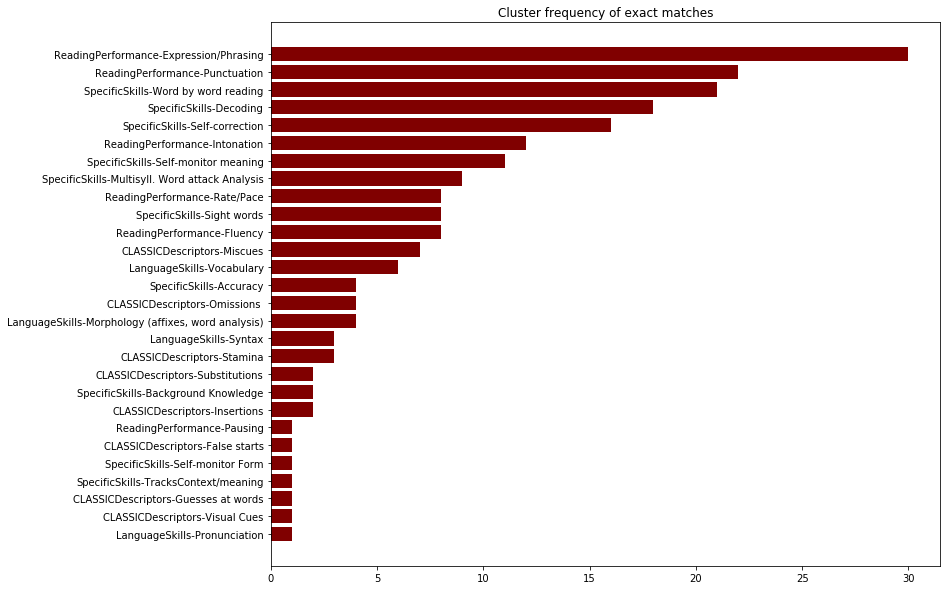

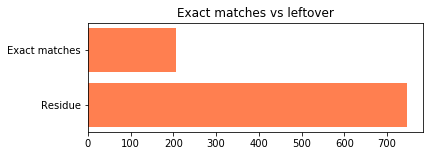

In [11]:
plt.figure(figsize=(13, 13))
plt.title('Cluster frequency of exact matches')
plt.pie(
    np.array(v), 
    labels=k
)

plt.figure(figsize=(12, 10))
plt.title('Cluster frequency of exact matches')
plt.barh(
    k[::-1],
    v[::-1],
    color='maroon'
)
plt.show()
plt.figure(figsize=(6,2))

matches_vs_residue = {
    'Residue': len(corpus) - matched,
    'Exact matches': matched
}
plt.title('Exact matches vs leftover')
plt.barh(
    range(len(matches_vs_residue)), 
    list(matches_vs_residue.values()), 
    align='center',
    color='coral'
)
plt.yticks(range(len(matches_vs_residue)),
    list(matches_vs_residue.keys())
)
plt.show()

In [12]:
jac = lambda A, B: len(A & B) / len(A | B)

In [13]:
def sieve(corpus, epr=better_epr_iter, threshold=.9, verbose=False):
    cntr = Counter()
    categ_to_line = {}
    matched = 0
    passed_threshold = 0
    leftover = []
    for obs in corpus:
        not_found = True
        for epr_cluster in epr:
            if obs == epr_cluster[-1]:
                matched += 1
                cntr[epr_cluster[:-1]] += 1
                try:
                    categ_to_line[tuple(epr_cluster[:-1])].append(obs)
                except KeyError:
                    categ_to_line[tuple(epr_cluster[:-1])] = [obs]
                not_found = False
                break
        if not_found:
            for epr_cluster in epr:
                obs_tkns = set(obs.split())
                epr_ln_tkns = set(epr_cluster[-1].split())
                if jac(obs_tkns, epr_ln_tkns) > threshold:
                    try:
                        categ_to_line[tuple(epr_cluster[:-1])].append(obs)
                    except KeyError:
                        categ_to_line[tuple(epr_cluster[:-1])] = [obs]
                    passed_threshold += 1
                    not_found = False
                    break
        if not_found:
            leftover.append(obs)
    if verbose:
        print('Exact matches:', matched)
        print('Lines that passed {:.1f}% threshold: {}'.format(
            threshold * 100,
            passed_threshold
        ))
    ret = (matched + passed_threshold) / len(corpus)
    print('{:.2f}'.format(ret), end=' ')
    return ret, leftover, categ_to_line

0.44 0.44 0.44 0.43 0.43 0.41 0.36 0.36 0.35 0.35 0.32 0.32 0.31 0.30 0.30 0.26 0.26 0.26 0.24 0.24 0.24 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.22 

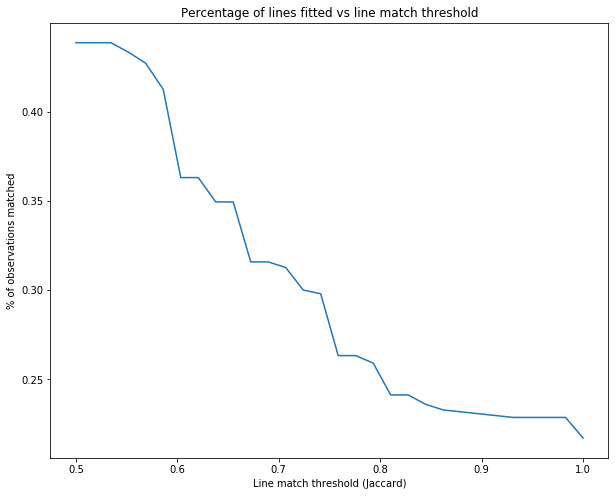

In [14]:
xr = np.linspace(.5, 1, 30)
received = [sieve(corpus, threshold=x)[0] for x in xr]
plt.figure(figsize=(10, 8))
plt.title('Percentage of lines fitted vs line match threshold')
plt.plot(xr, received)
plt.xlabel('Line match threshold (Jaccard)')
plt.ylabel('% of observations matched')
plt.show()

In [15]:
pct, leftover, categ_to_line = sieve(corpus, threshold=.75)

0.26 

In [25]:
ps = PorterStemmer()
def filter_(req_words, corpus):
    for req_words_set in req_words:
        assert type(req_words_set) == type(set())
    stemmed_req_words = [{ps.stem(wd) for wd in req_words_set} for req_words_set in req_words]
    caught = []
    not_caught = []
    for line in corpus:
        stemmed = set([ps.stem(x) for x in line.strip().split()])
        distinct = False
        for stemmed_set in stemmed_req_words:
            if stemmed_set & stemmed == set():
                distinct = True
        if not distinct:
            caught.append(line)
        else:
            not_caught.append(line)
    return caught, not_caught

difficulty_text, _leftover = filter_([
    {'text', 'passage'},
    {'easy', 'challenging', 'difficult', 'level', 'hard'}
], leftover)

self_correct_text, _leftover = filter_([
    {'self-correct', 'correct', 'self'}
], _leftover)

accuracy_text, _leftover = filter_([
    {'accurate', 'accuracy', 'miscue', 'misread'}
], _leftover)

fluency_text, _leftover = filter_([
    {'fluency', 'fluent', 'fluently', 'disfluent', 'intonation', 'decode', 'word-by-word', 'choppy'}
], _leftover)

pronunciation_text, _leftover = filter_([
    {'pronounce', 'pronunciation', 'enunciate', 'mispronounce', 'mispronunciation', 'attack'}
], _leftover)

phrasing_text, _leftover = filter_([
    {'phrasing'}
], _leftover)

meaning_text, _leftover = filter_([
    {'understanding', 'meaning', 'comprehension'}
], _leftover)

speed_text, _leftover = filter_([
    {'fast', 'quick', 'slow', 'slowly', 'rush', 'rate', 'quickly', 'pace'}
], _leftover)

subst_omit_text, _leftover = filter_([
    {'substitution', 'omission', 'omit', 'insert'}
], _leftover)

punctuation_text, _leftover = filter_([
    {'punctuation'}
], _leftover)

expression_text, _leftover = filter_([
    {'expression', 'monotone'}
], _leftover)

volume_text, _leftover = filter_([
    {'quiet', 'volume'}
], _leftover)

sight_text, _leftover = filter_([
    {'sight'}
], _leftover)

In [26]:
print(len(leftover) - len(_leftover))
len(_leftover)

548


154

In [27]:
main_fields = {tpl[:2] for tpl in better_epr_iter}

In [28]:
import pickle
pickle.dump(
    main_fields, 
    open('PklData/epr_main_fields.pkl', 'wb')
)

In [29]:
pickle.dump(
    _leftover, 
    open('PklData/leftover_lines.pkl', 'wb')
)

In [30]:
manually_filtered = {
    'MAN_difficulty': difficulty_text,
    'MAN_accuracy': accuracy_text,
    'MAN_fluency': fluency_text,
    'MAN_pronunciation': pronunciation_text,
    'MAN_phrasing': phrasing_text,
    'MAN_meaning': meaning_text,
    'MAN_speed': speed_text,
    'MAN_subst_omit': subst_omit_text,
    'MAN_punctuation': punctuation_text,
    'MAN_self_correct': self_correct_text,
    'MAN_expression': expression_text,
    'MAN_volume': volume_text,
    'MAN_sight': sight_text
}

In [31]:
pickle.dump(
    manually_filtered,
    open('PklData/manually_filtered.pkl', 'wb')
)

In [32]:
pickle.dump(
    categ_to_line,
    open('PklData/with_epr.pkl', 'wb')
)

In [33]:
sum([len(y) for x, y in manually_filtered.items()])

548

In [35]:
sum([len(y) for x, y in categ_to_line.items()])

251

In [38]:
for x in categ_to_line: print(len(categ_to_line[x]))

35
17
9
7
12
35
21
4
2
8
3
8
14
2
2
12
3
10
1
6
3
26
1
1
2
4
2
1
